<a href="https://colab.research.google.com/github/ocalzada/DS-Unit-2-Applied-Modeling/blob/master/module2/assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [X] Continue to clean and explore your data. Make exploratory visualizations.
- [X] Fit a model. Does it beat your baseline?
- [X] Try xgboost.
- [X] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
from google.colab import files
uploaded = files.upload()

Saving new-york-city-airbnb-open-data.zip to new-york-city-airbnb-open-data.zip


In [2]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [0]:
import pandas as pd

df = pd.read_csv('AB_NYC_2019.csv')
df

In [6]:
import pandas_profiling

pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,48895
Total Missing (%),2.6%
Total size in memory,6.0 MiB
Average record size in memory,128.0 B
Numeric,10
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [7]:
# baseline mae

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['price']
y_pred = [y.mean()] * len(y)

print('Mean Baseline:')
print('Mean Absolute Error:', mean_absolute_error(y, y_pred))

Mean Baseline:
Mean Absolute Error: 92.45104388371705


In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20,
                              random_state=42)

In [0]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                             random_state=42)

In [0]:
def wrangle(X):
  X = X.copy()
  
  cols_with_zeros = ['number_of_reviews', 'availability_365', 'reviews_per_month']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
        
  # Drop id (always varies, random)
  unusable_variance = ['id', 'name']
  X = X.drop(columns=unusable_variance)
  
  # return the wrangled dataframe
  return X 

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange into X features matrix and y vector target

target = 'price'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [24]:
!pip install category_encoders

In [25]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation R^2:', -pipeline.score(X_val, y_val))

Validation R^2: -0.0457215367932674


In [26]:
y_pred = pipeline.predict(X_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 72.1919280419223


In [0]:
# YAY! Validation MAE improved on baseline by $20!!

In [27]:
from xgboost import XGBRegressor

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:52:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['host_name', 'neighbourhood_group',
                                      'neighbourhood', 'room_type',
                                      'last_review'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'host_name',
                                          'data_type': dtype('O'),
                                          'mapping': Sarah                  1
Mey                    2
Kseniya                3
Dustin                 4
Patrick                5
Sebastian              6
Jackie                 7
Delphina               8
Carla                  9
Shirley               10
Sond...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_ty

In [28]:
y_pred = pipeline.predict(X_val)
print('Validation MAE:', mean_absolute_error(y_val, y_pred))

Validation MAE: 67.61021298883152


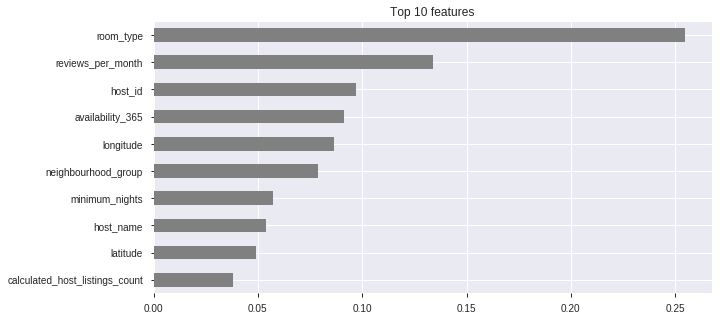

In [32]:
# Get feature importances
rf = pipeline.named_steps['xgbregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n=10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')
plt.show()

In [33]:
feature = 'room_type'
X_val[feature].head()

27408       Private room
7741     Entire home/apt
4771     Entire home/apt
1719        Private room
19153    Entire home/apt
Name: room_type, dtype: object

In [34]:
X_val[feature].value_counts(normalize=True)

Entire home/apt    0.524923
Private room       0.450409
Shared room        0.024668
Name: room_type, dtype: float64

In [0]:
import numpy as np

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

In [36]:
X_val_permuted[feature].head()

27408    Entire home/apt
7741        Private room
4771     Entire home/apt
1719     Entire home/apt
19153    Entire home/apt
Name: room_type, dtype: object

In [37]:
X_val_permuted[feature].value_counts(normalize=True)

Entire home/apt    0.524923
Private room       0.450409
Shared room        0.024668
Name: room_type, dtype: float64

In [39]:
# Get the permutation importances
# No need to refit pipeline

score_with = mean_absolute_error(y_val, y_pred)
y_pred2 = pipeline.predict(X_val_permuted)

score_without = mean_absolute_error(y_val, y_pred2)

print(f'Validation MAE with {feature}: {score_with}')
print(f'Validation MAE with {feature} permuted: {score_without}')
print(f'Permutation Importance: {score_with - score_without}')

Validation MAE with room_type: 67.61021298883152
Validation MAE with room_type permuted: 94.13744147947718
Permutation Importance: -26.527228490645655


In [40]:
feature = 'latitude'

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])

score_with = mean_absolute_error(y_val, y_pred)
y_pred3 = pipeline.predict(X_val_permuted)

score_without = mean_absolute_error(y_val, y_pred3)

print(f'Validation MAE with {feature}: {score_with}')
print(f'Validation MAE with {feature} permuted: {score_without}')
print(f'Permutation Importance: {score_with - score_without}')

Validation MAE with latitude: 67.61021298883152
Validation MAE with latitude permuted: 89.54957274720834
Permutation Importance: -21.939359758376824


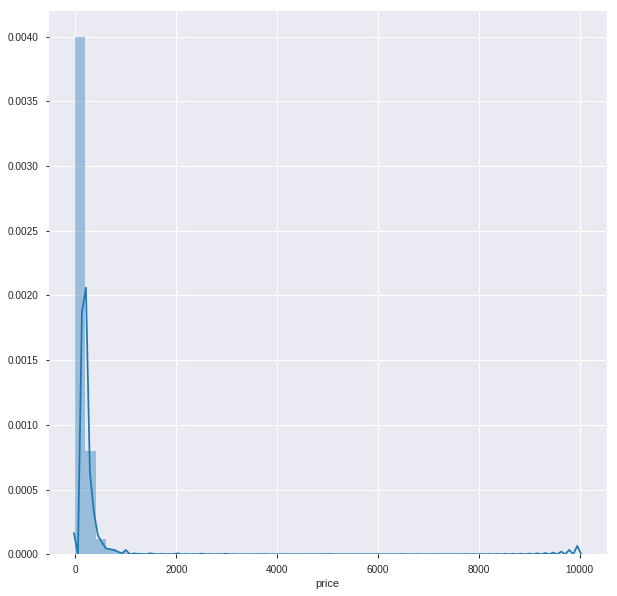

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax = sns.distplot(df['price'] )